In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
from shapely import wkt
from libpysal import weights

from cycler import cycler
from matplotlib import pyplot as plt

# global plotting settings
plt.style.use(['ggplot'])


default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (15, 5)
                    })


/home/otto/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/otto/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# geopandas

In [2]:
glim = xr.open_dataset('./glim_wgs84_0point5deg_Raster.nc').to_dataframe().reset_index()
glim = glim.rename(columns={'glim_wgs84_0point5deg.tif' : 'glim',
                           'x' : 'longitude',
                           'y' : 'latitude'})

glim = gpd.GeoDataFrame(glim, 
                        geometry=gpd.GeoSeries.from_xy(glim.longitude, glim.latitude), 
                        crs='epsg:4326')

# replace missing data (-9999, 15, 0)
# ignore unconsol (1), metamorphic (8), pyroclastic (12), water bodies (11), evaporite (14), ice and glacier (16)
litho = ( glim.replace([-9999, 15, 0, 1, 11, 16, 8, 12, 14], np.nan)
              .replace([2, 4, 7, 9, 10, 13], 2)
              .replace([3, 5, 6], 3)
              .assign(contact1 = np.zeros(len(glim)),
                      contact2 = np.zeros(len(glim)))
        )

wq = weights.contiguity.Queen.from_dataframe(litho)

contact1 = 2
contact2 = 3

for i in range(len(litho)):
    if (litho.glim.iloc[i] == contact1) & (litho.loc[wq.neighbors[i]].glim == contact2).any():
        litho.loc[i, 'contact1'] = True

for i in range(len(litho)):
    if (litho.glim.iloc[i] == contact2) & (litho.loc[wq.neighbors[i]].glim == contact1).any():
        litho.loc[i, 'contact2'] = True

/home/otto/anaconda3/lib/python3.8/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


In [7]:
# litho.to_file("litho.geojson", driver='GeoJSON')

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

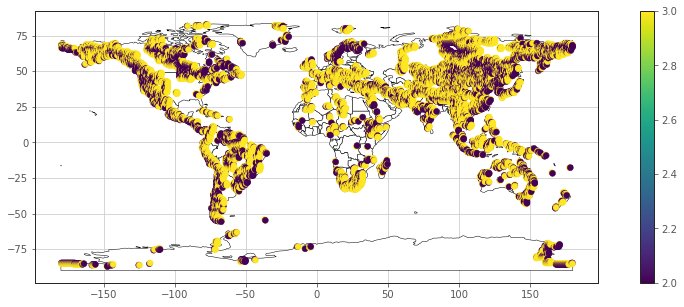

In [3]:
ax = world.plot(color='white', edgecolor='black')

mask = (litho['contact1']==True) | (litho['contact2']==True)

litho.loc[mask].plot(column='glim', legend=True, ax=ax)

(-30.0, -20.0)

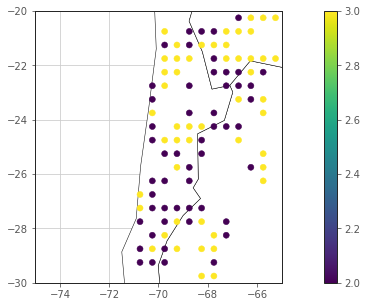

In [16]:
mask = (litho['contact1']==True) | (litho['contact2']==True)

xstart = -75
xstop = -65
ystart = -30
ystop = -20

ax = world.cx[xstart:xstop, ystart:ystop].plot(color='white', edgecolor='black')
litho.cx[xstart:xstop, ystart:ystop].loc[mask].plot(column='glim', legend=True, ax=ax)

ax.set_xlim(xstart, xstop)
ax.set_ylim(ystart,ystop)

(0.0, 50.0)

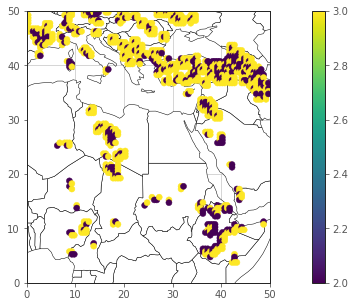

In [19]:
xstart = 0
xstop = 50
ystart = 0
ystop = 50

ax = world.cx[xstart:xstop, ystart:ystop].plot(color='white', edgecolor='black')
litho.cx[xstart:xstop, ystart:ystop].loc[mask].plot(column='glim', legend=True, ax=ax)

ax.set_xlim(xstart, xstop)
ax.set_ylim(ystart, ystop)

(17.0, 30.0)

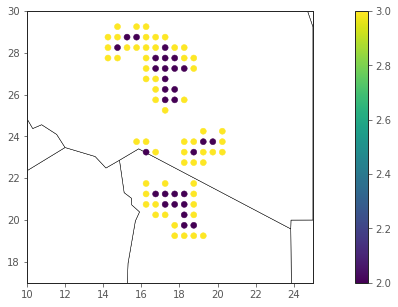

In [20]:
mask = (litho['contact1']==True) | (litho['contact2']==True)

xstart = 10
xstop = 25
ystart = 17
ystop = 30

ax = world.cx[xstart:xstop, ystart:ystop].plot(color='white', edgecolor='black')
litho.cx[xstart:xstop, ystart:ystop].loc[mask].plot(column='glim', legend=True, ax=ax)

ax.set_xlim(xstart, xstop)
ax.set_ylim(ystart, ystop)

# All experimental stuff below here

In [4]:
litho.sindex

rtree.index.Index(bounds=[-179.75, -89.75, 179.75, 89.75], size=259200)

In [16]:
litho.sindex.nearest((litho.geometry.x, litho.geometry.y))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Misguided attempt .buffer / .within()

In [4]:
buff = litho.geometry.buffer(0.75, 2)
buff

0         POLYGON ((-179.000 89.750, -179.220 89.220, -1...
1         POLYGON ((-179.000 89.250, -179.220 88.720, -1...
2         POLYGON ((-179.000 88.750, -179.220 88.220, -1...
3         POLYGON ((-179.000 88.250, -179.220 87.720, -1...
4         POLYGON ((-179.000 87.750, -179.220 87.220, -1...
                                ...                        
259195    POLYGON ((180.500 -87.750, 180.280 -88.280, 17...
259196    POLYGON ((180.500 -88.250, 180.280 -88.780, 17...
259197    POLYGON ((180.500 -88.750, 180.280 -89.280, 17...
259198    POLYGON ((180.500 -89.250, 180.280 -89.780, 17...
259199    POLYGON ((180.500 -89.750, 180.280 -90.280, 17...
Length: 259200, dtype: geometry

In [ ]:
for i in range(len(litho)):
    print(litho.geometry.within(buff.iloc[2]))

0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 

0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool
0         False
1          True
2          True
3          True
4         False
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 

In [10]:
litho.geometry.within(buff.iloc[i])

0         False
1         False
2         False
3          True
4          True
          ...  
259195    False
259196    False
259197    False
259198    False
259199    False
Length: 259200, dtype: bool

In [12]:
i=len(litho)-2
(litho.glim.iloc[i] == contact1) & (litho.loc[litho.geometry.within(buff.iloc[i])].glim == contact2).any()

False

In [49]:
i=litho.longitude[1]
j=litho.latitude[0]
litho.cx[i,j]

,longitude,latitude,glim,geometry,contact
0,-179.75,89.75,NaN,POINT (-179.75000 89.75000),0.0


In [4]:
i=0
j=-180
(litho.cx[i-0.5:i+0.5, i-0.5:i+0.5])

,longitude,latitude,glim,geometry,contact
129419,-0.25,0.25,NaN,POINT (-0.25000 0.25000),0.0
129420,-0.25,-0.25,NaN,POINT (-0.25000 -0.25000),0.0
129779,0.25,0.25,NaN,POINT (0.25000 0.25000),0.0
129780,0.25,-0.25,NaN,POINT (0.25000 -0.25000),0.0


In [ ]:
for i in range(len(litho)):
    if (litho.glim.iloc[i] == contact1) & (litho.loc[litho.geometry.within(buff.iloc[i])].glim == contact2).any():
        litho.loc[i, 'contact'] = True

In [68]:
(litho.cx[long,lat].glim == contact1).any()

False

In [36]:
i=litho.longitude[0]
(litho.cx[i,i] == contact1) & (litho.cx[i-1:i+1, i-1:i+1].glim == contact2).any()

<ipython-input-36-f7e7682881f5>:2: DeprecationWarning: '&' operator will be deprecated. Use the 'intersection' method instead.
  (litho.cx[i,i] == contact1) & (litho.cx[i-1:i+1, i-1:i+1].glim == contact2).any()


TypeError: (<class 'geopandas.geoseries.GeoSeries'>, <class 'numpy.bool_'>)

In [34]:
np.arange(litho.longitude.min(), litho.longitude.max())

array([-179.75, -178.75, -177.75, -176.75, -175.75, -174.75, -173.75,
       -172.75, -171.75, -170.75, -169.75, -168.75, -167.75, -166.75,
       -165.75, -164.75, -163.75, -162.75, -161.75, -160.75, -159.75,
       -158.75, -157.75, -156.75, -155.75, -154.75, -153.75, -152.75,
       -151.75, -150.75, -149.75, -148.75, -147.75, -146.75, -145.75,
       -144.75, -143.75, -142.75, -141.75, -140.75, -139.75, -138.75,
       -137.75, -136.75, -135.75, -134.75, -133.75, -132.75, -131.75,
       -130.75, -129.75, -128.75, -127.75, -126.75, -125.75, -124.75,
       -123.75, -122.75, -121.75, -120.75, -119.75, -118.75, -117.75,
       -116.75, -115.75, -114.75, -113.75, -112.75, -111.75, -110.75,
       -109.75, -108.75, -107.75, -106.75, -105.75, -104.75, -103.75,
       -102.75, -101.75, -100.75,  -99.75,  -98.75,  -97.75,  -96.75,
        -95.75,  -94.75,  -93.75,  -92.75,  -91.75,  -90.75,  -89.75,
        -88.75,  -87.75,  -86.75,  -85.75,  -84.75,  -83.75,  -82.75,
        -81.75,  -80

In [21]:
i=0
j=-180
(litho.cx[i-0.5:i+0.5, i-0.5:i+0.5])

,longitude,latitude,glim,geometry,contact
129419,-0.25,0.25,NaN,POINT (-0.25000 0.25000),0.0
129420,-0.25,-0.25,NaN,POINT (-0.25000 -0.25000),0.0
129779,0.25,0.25,NaN,POINT (0.25000 0.25000),0.0
129780,0.25,-0.25,NaN,POINT (0.25000 -0.25000),0.0


In [ ]:
for i in range(len(litho)):
    if (litho.glim.iloc[i] == contact1) & (litho.loc[litho.geometry.within(buff.iloc[i])].glim == contact2).any():
        litho.loc[i, 'contact'] = True

In [ ]:
litho.loc[litho.contact==True]

In [ ]:
for i=2:sz(1)-1:
    for j=2:sz(2)-1:
        if litho(i,j)==contact2 && litho(i+1,j)==contact1:
            contact(i,j)=1
        end
        
        if litho(i,j)==contact2 && litho(i+1,j+1)==contact1
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact2 && litho(i+1,j-1)==contact1
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact2 && litho(i,j+1)==contact1
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact2 && litho(i,j-1)==contact1
            contact(i,j)=1;
       end
        
        
        if litho(i,j)==contact2 && litho(i-1,j)==contact1
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact2 && litho(i-1,j+1)==contact1
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact2 && litho(i-1,j-1)==contact1
            contact(i,j)=1;
        end
            
    end
    
end

for i=2:sz(1)-1
    for j=2:sz(2)-1
        if litho(i,j)==contact1 && litho(i+1,j)==contact2
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact1 && litho(i+1,j+1)==contact2
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact1 && litho(i+1,j-1)==contact2
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact1 && litho(i,j+1)==contact2
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact1 && litho(i,j-1)==contact2
            contact(i,j)=1;
       end
        
        
        if litho(i,j)==contact1 && litho(i-1,j)==contact2
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact1 && litho(i-1,j+1)==contact2
            contact(i,j)=1;
        end
        
        if litho(i,j)==contact1 && litho(i-1,j-1)==contact2
            contact(i,j)=1;
        end
            
    end
    
end


In [126]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [44]:
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

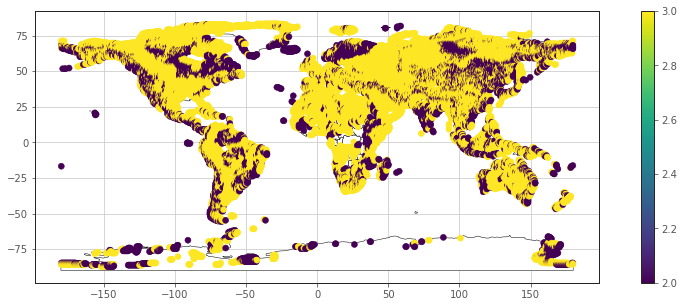

In [22]:
ax = world.plot(color='white', edgecolor='black')

litho.plot(column='glim', ax=ax, legend=True)
# # We can now plot our ``GeoDataFrame``.
# glim['glim'].plot(ax=ax, cmap='OrRd')

<AxesSubplot:>

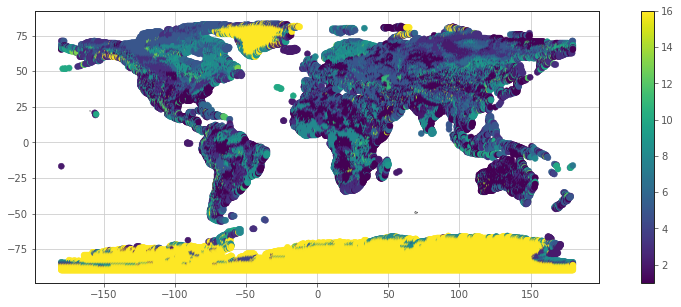

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ax = world.plot(
    color='white', edgecolor='black')

glim.plot(column='glim', ax=ax, legend=True)

# # We can now plot our ``GeoDataFrame``.
# glim['glim'].plot(ax=ax, cmap='OrRd')


# rioxarray / rasterio

In [90]:
rds = rioxarray.open_rasterio('./glim_wgs84_0point5deg_Raster.nc')

In [119]:
rds = rds.where(rds != -9999)
rds = rds.where(rds != 15)
rds = rds.where(rds != 0)
rds = rds.where(rds != 1)
rds = rds.where(rds != 11)
rds = rds.where(rds != 16)
rds = rds.where(rds != 8)
rds = rds.where(rds != 14)
rds = rds.where(rds != 12)

rds.values[rds.isin([4, 7, 9, 10, 13]).values] = 2
rds.values[rds.isin([5, 6]).values] = 3

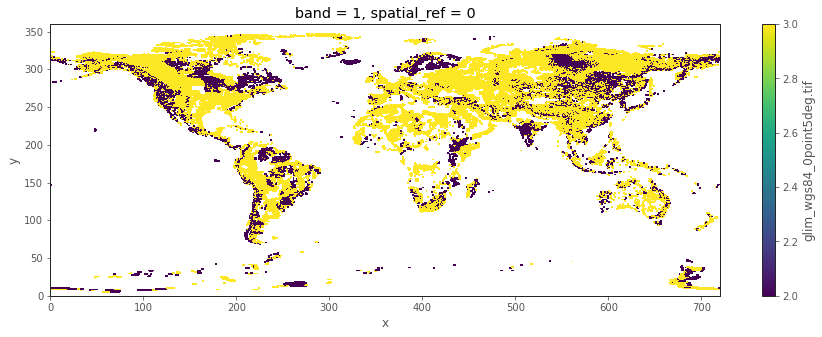

In [124]:
rds.plot()

In [ ]:
rds.rio.

In [76]:
rds = rds.where(! rds.isin([4, 7, 9, 10, 13]), 2)

SyntaxError: invalid syntax (<ipython-input-76-d64e7e3190b2>, line 2)

In [63]:
litho = ( glim.replace([-9999, 15, 0, 1, 11, 16, 8, 12, 14], np.nan)
              .replace([2, 4, 7, 9, 10, 13], 2)
              .replace([3, 5, 6], 3)
              .assign(contact = np.zeros(len(glim)))
        )

In [67]:
rds = rds.rio.write_crs(4326)

In [20]:
crs = 'espg:4326'
rds.crs = crs

AttributeError: cannot set attribute 'crs' on a 'DataArray' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [24]:
rds.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'glim_wgs84_0point5deg.tif' (band: 1, y: 360, x: 720)>
[259200 values with dtype=int32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 716.5 717.5 718.5 719.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    spatial_ref  int64 0
Attributes:
    long_name:      glim_wgs84_0point5deg.tif
    missing_value:  -9999
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [25]:
rds.crs

AttributeError: 'DataArray' object has no attribute 'crs'

In [5]:
rds.squeeze()

<xarray.DataArray 'glim_wgs84_0point5deg.tif' (y: 360, x: 720)>
[259200 values with dtype=int32]
Coordinates:
    band         int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 716.5 717.5 718.5 719.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    spatial_ref  int64 0
Attributes:
    long_name:      glim_wgs84_0point5deg.tif
    missing_value:  -9999
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "data"
df = rds.to_dataframe().reset_index()
# df[df.data>=0.0].to_csv("out.csv", index=False)

In [8]:
df

,y,x,data
0,0.5,0.5,16
1,0.5,1.5,16
2,0.5,2.5,16
3,0.5,3.5,16
4,0.5,4.5,16
...,...,...,...
259195,359.5,715.5,-9999
259196,359.5,716.5,-9999
259197,359.5,717.5,-9999
259198,359.5,718.5,-9999


In [28]:
glim = pd.read_csv('./glim/glim_wgs84_0point5deg.txt.asc', sep=r'\s{2,}', skiprows=5, names=[])

<ipython-input-28-ebf35f9a7a9d>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  glim = pd.read_csv('./glim/glim_wgs84_0point5deg.txt.asc', sep=r'\s{2,}', skiprows=5, names=[])


In [29]:
glim

,0,1
0,NODATA_value,-9999.0
1,-9999 -9999 -9999 -9999 -9999 -9999 -9999 -999...,NaN
2,-9999 -9999 -9999 -9999 -9999 -9999 -9999 -999...,NaN
3,-9999 -9999 -9999 -9999 -9999 -9999 -9999 -999...,NaN
4,-9999 -9999 -9999 -9999 -9999 -9999 -9999 -999...,NaN
...,...,...
356,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,NaN
357,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,NaN
358,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,NaN
359,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,NaN


In [30]:
range(-179.75, 179.75, 0.5)

TypeError: 'float' object cannot be interpreted as an integer

In [8]:
glim = gpd.read_file('./glim/glim_wgs84_0point5deg.txt.asc', sep=r'\s{2,}')

DriverError: './glim/glim_wgs84_0point5deg.txt.asc' not recognized as a supported file format.